# Getting Started

This document aims to guide the challenge particpants with limited exposure to Synapse as a platform and clinical/biological data, through exploration and analysis of the available RNASeq datasets. The available dataset has been carefully curated to include gene expression (RNASeq) data from seven different tumor types from four different study initiatives into a single platform (a harmonized dataset). 

The scope of this document is to inform participants:

* how to navigate the Synapse environment to access and work with the data files
* display the key features of the gene-expression (RNASeq) dataset 
* introduce few general analyses steps of the data and their interpretation

At the end of this document, the participants would be able to download the data and understand various intricacies that exists in this given dataset. We encourage participants to visualize the dataset by faceting on different variables to get an accurate understanding of the dataset. 


## Logging in to Synapse

Please download your Synapse client for [Python](https://python-docs.synapse.org//build/html/index.html) and refer to the necessary docs [Python](https://python-docs.synapse.org//build/html/index.html) to successfully log in to synapse and start using its various analytical tools.



In [167]:
import synapseclient

syn = synapseclient.Synapse()

## log in using username and password
syn.login()

Welcome, jineta.banerjee!



In [168]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.style as style
style.use('ggplot')
#style.use('Solarize_Light2')
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
from pylab import *

# ignore FutureWarning that may pop up when plotting
import warnings
warnings.filterwarnings("ignore")
import urllib3
urllib3.disable_warnings()

from dfply import *

# For PCA
from sklearn.decomposition import PCA

## Accessing or downloading data from Synapse

* Look up the SynID of the required file and then use the __syn.get__ command to access the file entity. 
* Download the required gene expression data and store it as a dataframe


In [170]:
entity = syn.get('syn20449214')
#entity.id

In [171]:
results = syn.tableQuery("SELECT * FROM syn20449214")
genes_with_meta = results.asDataFrame()

In [172]:
#Clean up data format
genes_with_meta = genes_with_meta.replace(to_replace = "male", value = "Male")
genes_with_meta = genes_with_meta.replace(to_replace = "female", value = "Female")
genes_with_meta = genes_with_meta.rename(columns={'used': 'id'})
genes_with_meta = genes_with_meta.reset_index()
genes_with_meta = genes_with_meta.drop(labels=["index", "path"], axis =1)

#Quality control
#removing any rows or columns with uncompliant values
genes_with_meta = genes_with_meta[genes_with_meta.totalCounts != "Male"]

# Explore the data files

## Structure of the file

In [173]:
print("Contents of the file:")
genes_with_meta.head()

Contents of the file:


,totalCounts,Symbol,zScore,specimenID,parent,individualID,assay,dataType,sex,consortium,...,species,fundingAgency,resourceType,nf1Genotype,nf2Genotype,studyName,id,age,isCellLine,experimentalCondition
0,136.993,A1BG,-0.226861,patient10tumor1,syn18407530,patient10,rnaSeq,geneExpression,Male,CTF Biobank,...,Human,CTF,experimentalData,-/-,unknown,Cutaneous Neurofibroma Data Resource,syn20430744,NaN,NaN,NaN
1,168.454,A1BG,-0.248889,patient10tumor2,syn18407530,patient10,rnaSeq,geneExpression,Male,CTF Biobank,...,Human,CTF,experimentalData,-/-,unknown,Cutaneous Neurofibroma Data Resource,syn20430745,NaN,NaN,NaN
2,115.456,A1BG,-0.115625,patient10tumor3,syn18407530,patient10,rnaSeq,geneExpression,Male,CTF Biobank,...,Human,CTF,experimentalData,-/-,unknown,Cutaneous Neurofibroma Data Resource,syn20430746,NaN,NaN,NaN
3,500.304,A1BG,-0.184728,patient11tumor1,syn18407530,patient11,rnaSeq,geneExpression,Female,CTF Biobank,...,Human,CTF,experimentalData,-/-,unknown,Cutaneous Neurofibroma Data Resource,syn20430747,NaN,NaN,NaN
4,380.698,A1BG,-0.229165,patient11tumor14,syn18407530,patient11,rnaSeq,geneExpression,Female,CTF Biobank,...,Human,CTF,experimentalData,-/-,unknown,Cutaneous Neurofibroma Data Resource,syn20430748,NaN,NaN,NaN


In [174]:
print("Size of the file:")
print(genes_with_meta.shape)

Size of the file:
(6226820, 23)


The following table contains detailed descriptions of the metadata variables included in the data file:

Var | Description
--- | --- 
 _id_  |  the synapseIDs of the individual files with raw data
 _specimenID_  |  individual samples
 _species_  |  the source of the specimen
 _age_  |  the age of the patient 
 _Sex_  |  the sex of the patient
 _tumorType_  |  the the type of tumor, can be one of 7 different diagnoses
 _isCellLine_  |  indicates whether the origin tissue was a cell line or a patient
 _study_  |  the specific initiative/consortia that the study was a part of
 _Symbol_  |  the common names of genes 
 _cellCulture_  |  whether the data was obtained from a cell culture experiment or an _in-vivo_ experiment. Many inherent differences exist between _cell culture_ experiments and _in-vivo_ experiments. These differences may need to be taken into account during analysis and interpretation of the data
 _totalCounts_  |  the main measure of expression levels of the gene. _(the values documented here are not corrected for batch/study)_ 
 _zScore_  |  normalized counts (counts for a gene can vary significantly due to technical differences in different studies, so we normalized the counts into a zScore for a comparable measurement between samples for the same gene)

## Metadata 

The metadata in a healthcare study includes descriptions of the specimens, and the details of the studies they originated from. We can explore the metadata by visualizing various aspects of it to get a sense of the data contained within our dataset and put it in context of the disease and patients.

For example, we can visualize the data distribution according to sex.

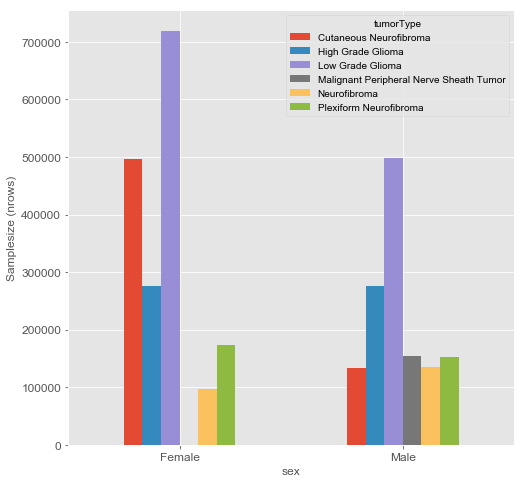

In [175]:
#select a particular column
genes_with_meta.sex = genes_with_meta['sex'].astype('category')
genes_with_meta.tumorType = genes_with_meta['tumorType'].astype('category')



genes_with_meta_table = pd.crosstab(index=genes_with_meta["sex"], 
                          columns=genes_with_meta["tumorType"])
genes_with_meta_table.plot(kind ='bar', figsize=(8,8), position= (0.5), fontsize= 12, rot=0)
plt.ylabel("Samplesize (nrows)", fontsize = 12)

plt.show()

## Visualizing expression of specific genes in different tumor types

We can further visualize the expression of specific genes in different tumorTypes to investigate the possible contribution of that gene to the progression of various tumorTypes.For example lets plot the expression levels of the genes _GFAP_ _(astrocyte-specific marker gene)_, _NF1_ _(neurofibromin 1 gene)_, _NF2_ _(neurofibromin 2 gene)_ in different tumortypes. Since our datasets contain human data, make sure to include gene names specific to humans.


Text(0, 0.5, 'Expression (zScore)')

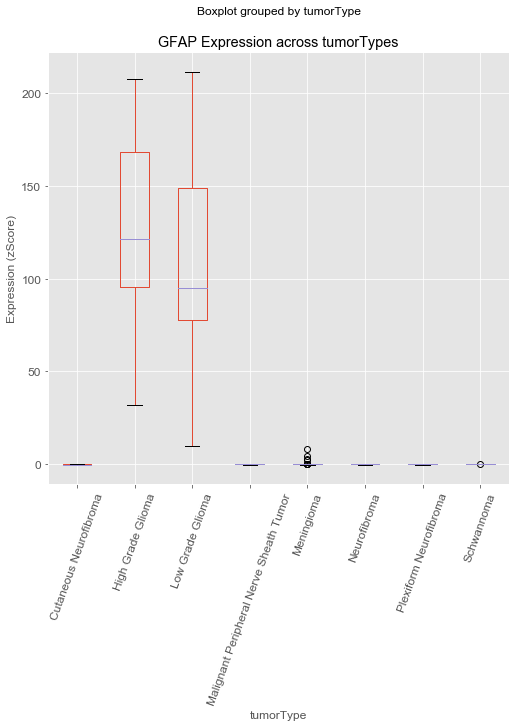

In [176]:
GFAP = genes_with_meta[genes_with_meta["Symbol"] =="GFAP"]

GFAP.boxplot(column='zScore', by= 'tumorType',figsize =(8,8), fontsize=12, rot=70, grid=True)
plt.title("GFAP Expression across tumorTypes")
plt.ylabel('Expression (zScore)', fontsize = 12)

Text(0, 0.5, 'Expression (zScore)')

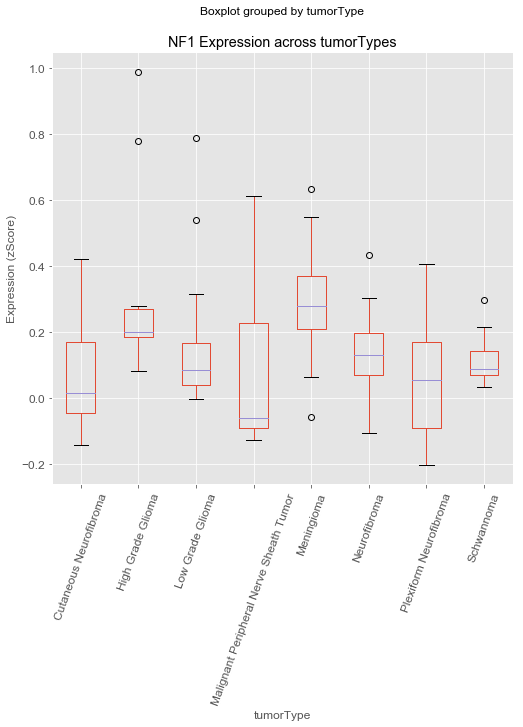

In [177]:
NF1 = genes_with_meta[genes_with_meta["Symbol"] =="NF1"]

NF1.boxplot(column='zScore', by= 'tumorType',figsize =(8,8), fontsize=12, rot=70, grid=True)
plt.title("NF1 Expression across tumorTypes")
plt.ylabel('Expression (zScore)', fontsize = 12)

Text(0, 0.5, 'Expression (zScore)')

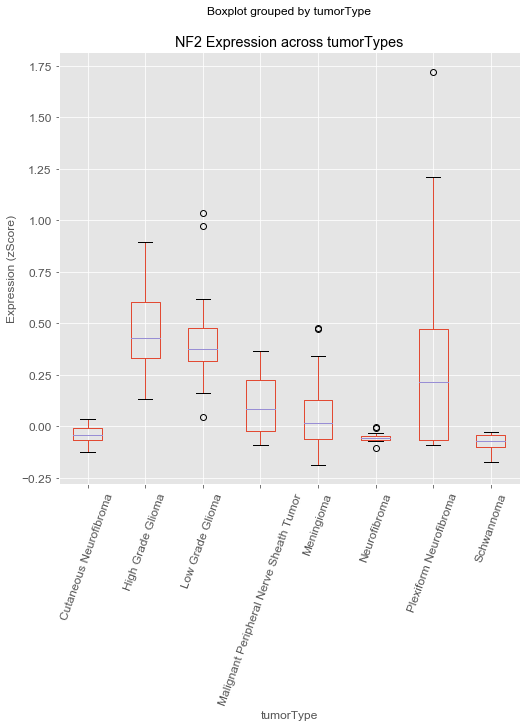

In [178]:
NF2 = genes_with_meta[genes_with_meta["Symbol"] =="NF2"]

NF2.boxplot(column='zScore', by= 'tumorType',figsize =(8,8), fontsize=12, rot=70, grid=True)
plt.title("NF2 Expression across tumorTypes")
plt.ylabel('Expression (zScore)', fontsize = 12)

# Data Analysis

## Dimensionality Reduction

To explore the data and find meaningful differences between samples, we first perform some dimensionality reduction using principal component analysis. We can then look at the genes that are top contributors to the first few principal components. We can utilize the zScore metric for PCA.

In [179]:
#Select specific columns for PCA
genes = genes_with_meta[["Symbol","specimenID","zScore"]]

#remove duplicates if any
genes = genes.drop_duplicates(keep="first")

# retype columns 
genes.Symbol = genes['Symbol'].astype('category')

In [180]:
#Make wide form dataframe from long form dataframe
genes_pca = genes.pivot_table(index="Symbol",
                       columns= "specimenID",
                       values="zScore")
# genes_pca.head()

#Clean up dataframe to avoid NaN
genes_pca_clean = genes_pca.dropna()
genes_pca_clean = genes_pca_clean.T
#genes_pca_clean.head()

In [181]:
#Perform PCA
from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(genes_pca_clean)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

#Extract Sample information to add to PCA plot
df = pd.pivot_table(genes,index="specimenID")
new_df = df.reset_index(level=['specimenID'])
#new_df.head()

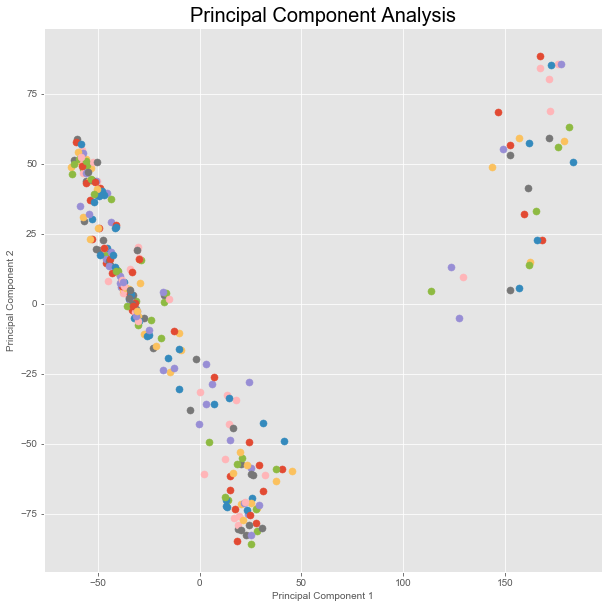

In [182]:
#Make DF for plotting
finalDf = pd.concat([principalDf, new_df[['specimenID']]], axis = 1)
#finalDf.head()

#Plot the PCA results 
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 2', fontsize = 10)
ax.set_title('Principal Component Analysis', fontsize = 20)
targets = finalDf['specimenID']
for target in targets:
    indicesToKeep = finalDf['specimenID'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
              # , c = 'b'
               , s = 50)

The PCA reveals two distinct clusters in the samples. We encourage the participants to find features in the gene expression profiles of the samples that may explain the source of variation in the dataset.